## mPyPl: Monadic Way to do Complex Data Processing in Python

This notebook contains materials from the presentations at PyCon Estonia, PyCon Balkan, SECR and PyCon India.

In [1]:
import sys
!{sys.executable} -m pip install --upgrade mPyPl

Requirement already up-to-date: mPyPl in c:\winapp\miniconda3\lib\site-packages (0.0.3.8)


### The Pain of Python

Computing frequency dictionary of a text file

In [5]:
!curl -o alice.txt https://www.gutenberg.org/files/11/11-0.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 17  170k   17 30455    0     0  30455      0  0:00:05  0:00:01  0:00:04 30004
100  170k  100  170k    0     0   170k      0  0:00:01  0:00:01 --:--:-- 94673


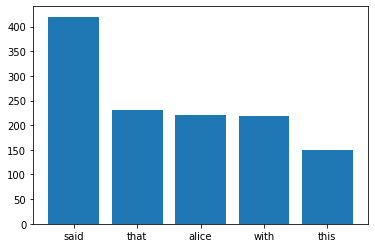

In [7]:
from itertools import groupby
import matplotlib.pyplot as plt

txt = open('alice.txt','r',encoding='utf-8').readlines()
words = sum(map(lambda x: x.lower().strip().split(),txt),[])
filtered = filter(lambda x:len(x)>3, words)
pairs = [ (k,len(list(g))) for k,g in groupby(sorted(filtered))]
res = sorted(pairs,key=lambda x:-x[1])[0:5]
plt.bar(list(range(5)),[x[1] for x in res])
plt.xticks(list(range(5)),labels=[x[0] for x in res])
plt.show()

## Using Pipe

There are [different options](https://stackoverflow.com/questions/28252585/functional-pipes-in-python-like-from-rs-magritrr![image.png](attachment:image.png) for using pipe-like operators in Python, but [Pipe library](https://pypi.org/project/pipe/) by Julien Palard is the best! 

In [8]:
from pipe import *

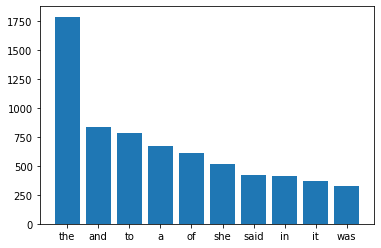

In [10]:
@Pipe
def bar(seq):
    n,l = zip(*enumerate(list(seq)))
    plt.bar(n,[x[1] for x in l])
    plt.xticks(n,labels=[x[0] for x in l])
    plt.show()
    
( open('alice.txt','r',encoding='utf8').readlines()
| select(lambda x: x.lower().strip().split())
| chain
| groupby(lambda x:x)
| select(lambda x: (x[0],len(list(x[1]))))
| sort(key=lambda x:-x[1])
| take(10)
| bar)

## Time-Stamping Pictures

Let's consider a problem where we need to pit date/time stamp onto a picture.

In [11]:
import cv2
import mPyPl as mp
from mPyPl.utils.image import im_load, show_images
import os, time

show = Pipe(lambda x: show_images(x))

In [22]:
import os
if not os.path.isdir('images'):
    !mkdir images
    !curl -L https://github.com/shwars/NeuroWorkshopData/raw/master/Data/Gates50.zip -o Gates50.zip
    !unzip -q Gates50.zip -d images
    !rm Gates50.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   148  100   148    0     0    148      0  0:00:01 --:--:--  0:00:01   729

  0 18.6M    0 12339    0     0  12339      0  0:26:26  0:00:01  0:26:25 12339
 40 18.6M   40 7783k    0     0  7783k      0  0:00:02  0:00:01  0:00:01 12.1M
100 18.6M  100 18.6M    0     0  9557k      0  0:00:02  0:00:02 --:--:-- 20.5M


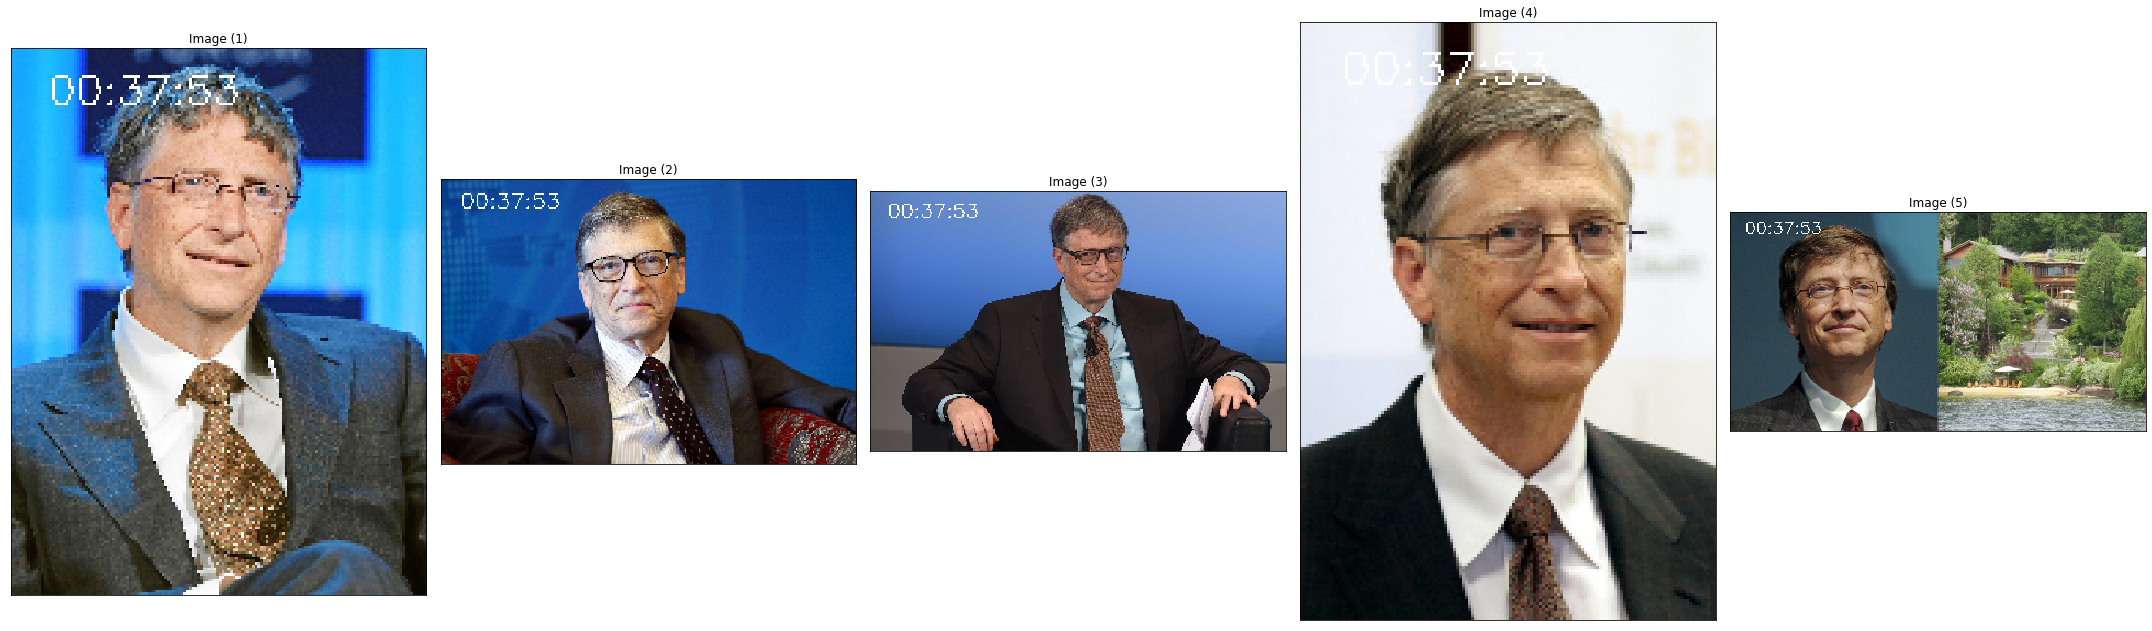

In [23]:
def imprint(img,txt):
    cv2.putText(img,txt, (5,20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255))
    return img

(mp.get_files('images')
 | take(5)
 | select(lambda x: (x,time.ctime(os.stat(x).st_ctime)[10:19]))
 | select(lambda x: (im_load(x[0],size=(None,200)),x[1]))
 | select(lambda x: imprint(*x))
 | show)

## mPyPl Solution

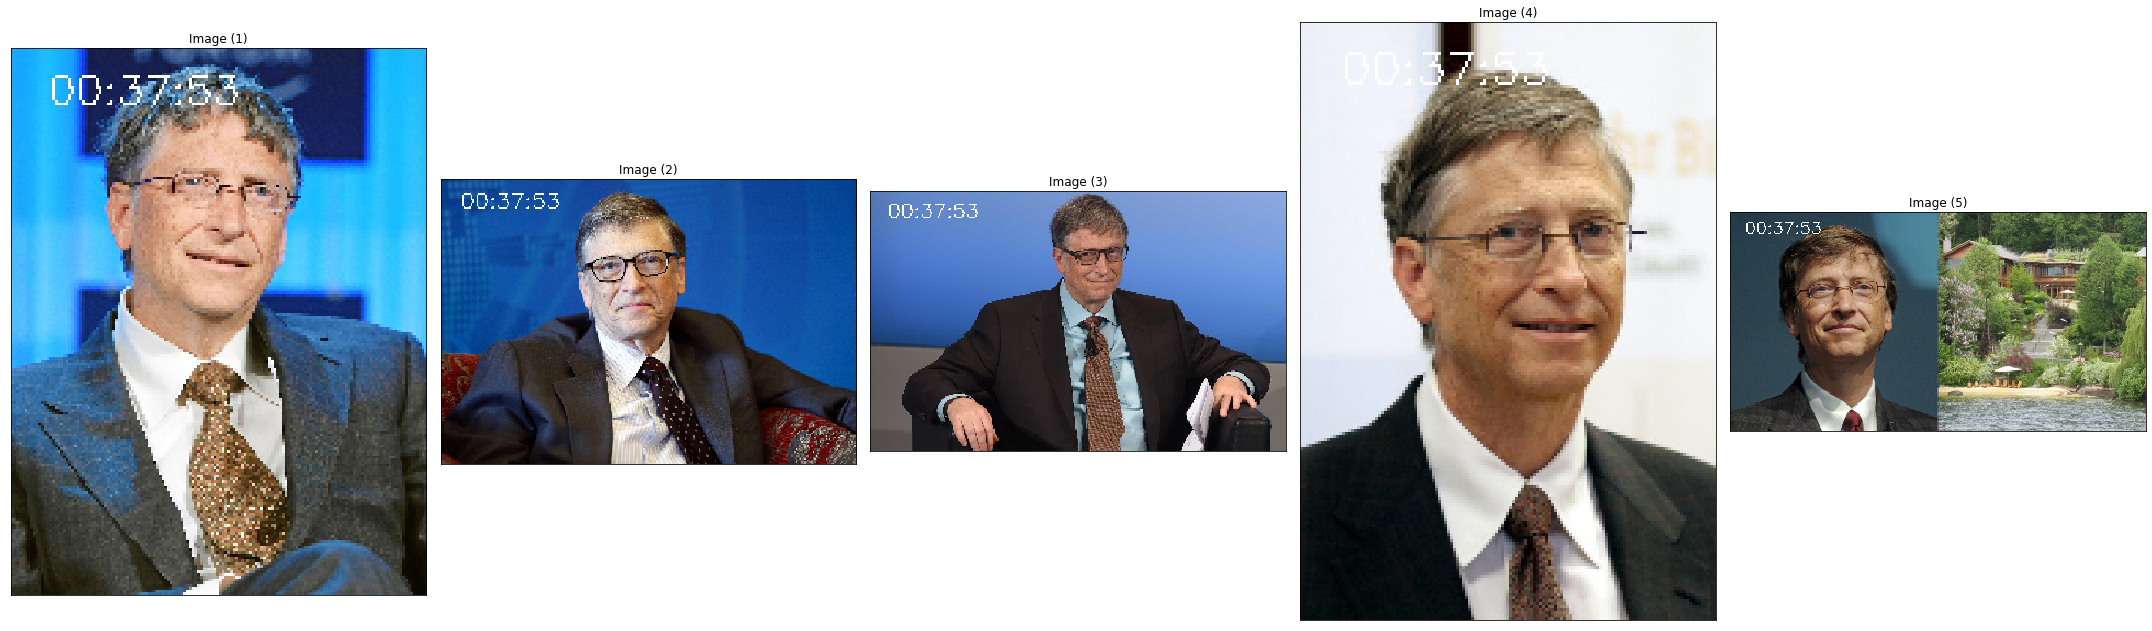

In [24]:
(mp.get_files('images')
 | mp.as_field('fname')
 | mp.take(5)
 | mp.apply('fname','time',lambda x: time.ctime(os.stat(x).st_ctime)[10:19])
 | mp.apply('fname','image',lambda x: im_load(x,size=(None,200)))
 | mp.apply(['image','time'],'res',lambda x: imprint(*x))
 | mp.select_field('res')
 | mp.pexec(show_images))

## Freq Dict via mPyPl

In [26]:
(open('alice.txt','r',encoding='utf8').readlines()
 | mp.as_field('line')
 | mp.apply('line','word',lambda x: x.lower().strip().split())
 | mp.unroll('word')
 | mp.take(10)
 | mp.as_list)

[{&#39;line&#39;: &#39;\ufeffThe Project Gutenberg EBook of Alice’s Adventures in Wonderland, by Lewis Carroll\n&#39;,
  &#39;word&#39;: &#39;\ufeffthe&#39;},
 {&#39;line&#39;: &#39;\ufeffThe Project Gutenberg EBook of Alice’s Adventures in Wonderland, by Lewis Carroll\n&#39;,
  &#39;word&#39;: &#39;project&#39;},
 {&#39;line&#39;: &#39;\ufeffThe Project Gutenberg EBook of Alice’s Adventures in Wonderland, by Lewis Carroll\n&#39;,
  &#39;word&#39;: &#39;gutenberg&#39;},
 {&#39;line&#39;: &#39;\ufeffThe Project Gutenberg EBook of Alice’s Adventures in Wonderland, by Lewis Carroll\n&#39;,
  &#39;word&#39;: &#39;ebook&#39;},
 {&#39;line&#39;: &#39;\ufeffThe Project Gutenberg EBook of Alice’s Adventures in Wonderland, by Lewis Carroll\n&#39;,
  &#39;word&#39;: &#39;of&#39;},
 {&#39;line&#39;: &#39;\ufeffThe Project Gutenberg EBook of Alice’s Adventures in Wonderland, by Lewis Carroll\n&#39;,
  &#39;word&#39;: &#39;alice’s&#39;},
 {&#39;line&#39;: &#39;\ufeffThe Project Gutenberg EBook of A

In [27]:
import itertools
@Pipe
def group_by(seq,fld,fld2):
    l = sorted(list(seq),key=lambda x:x[fld])
    for x,xs in itertools.groupby(l,key=lambda x:x[fld]):
        yield mp.mdict({fld:x,fld2:list(xs)})

(open('alice.txt','r').readlines()
 | mp.as_field('line')
 | mp.apply('line','word',lambda x: x.lower().strip().split())
 | mp.unroll('word')
 | mp.select_fields(['word'])
 | group_by('word','group')
 | mp.apply('group','count',len)
 | mp.delfield('group')
 | sort(key=lambda x:-x['count'])
 | mp.take(10)
 | mp.as_list)

UnicodeDecodeError: &#39;charmap&#39; codec can&#39;t decode byte 0x98 in position 1143: character maps to &lt;undefined&gt;

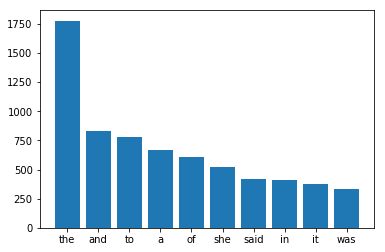

In [31]:
(open('alice.txt','r').readlines()
 | mp.as_field('line')
 | mp.apply('line','word',lambda x: x.lower().strip().split())
 | mp.unroll('word')
 | mp.select_fields(['word'])
 | group_by('word','group')
 | mp.apply('group','count',len)
 | mp.delfield('group')
 | sort(key=lambda x:-x['count'])
 | mp.take(10)
 | mp.select_field(['word','count'])
 | bar)

### Clean Up

In [28]:
!rm -fr alice.txt images